# BERT is a Stock Market Guru
<a href="https://ibb.co/nf4pDr4"><p style="text-align:center;"><img src="https://i.ibb.co/2PRJjqR/bertstonk.png" alt="bertstonk" border="0"></p></a>

In this notebook we present models that can be used for predicting stock market sentiments. We Approach the problem first by using an assortment of machine learning based approaches that include
- Random Forest
- Gradient Boosting
- AdaBoost
- LightGBM
- XGBoost
- Decision Tree
- Support Vector Machine
- Naive Bayes
- Multilayer Perceptron

We Find that the aformentioned approaches unpromising and so switch to a deep learning based approach where a Large Language Model (LLM), RoBERTa, in this case, which has been pretrained is finetuned to our task of sentiment classification, It proves to be much better than the machine learning based approaches and achieves an accuracy of 86.32% after just 5 epochs of fine tuning.

## Setup

In [1]:
%%capture
!pip install transformers
!pip install accelerate 
# uncomment below cell to train on TPU's
#!pip install cloud-tpu-client==0.10 torch==1.9.0 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl
!pip install git+https://github.com/huggingface/accelerate
!pip install ml_collections
!pip install datasets
!pip install pandas-profiling[notebook]

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import ml_collections
import datasets
import torch
import transformers
from accelerate import Accelerator, DistributedType
from datasets import load_metric, Dataset, DatasetDict
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    get_linear_schedule_with_warmup,
    set_seed,
)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, precision_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import emoji
from wordcloud import WordCloud, STOPWORDS
import re,string, nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.stem.snowball import SnowballStemmer

from pandas_profiling import ProfileReport

import warnings
warnings.filterwarnings(action="ignore")

2022-02-27 19:15:29.997724: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [3]:
# Setting up the model hyperparameters

def model_config():
    cfg_dictionary = {
        "data_path": "../input/financial-sentiment-analysis/data.csv",
        "model_path": "/kaggle/working/bert_model.h5",
        "model_type": "transformer",

        "test_size": 0.1,
        "validation_size":0.2,
        "train_batch_size": 32,
        "eval_batch_size": 32,

        "epochs": 5,
        "adam_epsilon": 1e-8,
        "lr": 3e-5,
        "num_warmup_steps": 10,

        "max_length": 128,
        "random_seed": 42,
        "num_labels": 3,
        "model_checkpoint":"roberta-base",
    }
    cfg = ml_collections.FrozenConfigDict(cfg_dictionary)

    return cfg
cfg = model_config()

## Preprocessing

Almost all text we find is unsanitised and contains many characters that can trip up out model, we perform a regime of cleaning steps that remove URL's, Emoji's, Special Characters that appear very infrequenty in the english language. When it comes to applying non deep learning models, such as XGBoost, Decision Trees etc, we perfom stemming and lemmatization that further simplifies the word in the text. For, Large Language Models (LLM's) these preporcessing steps seem unnessary, and so we skip them. 

In [4]:
def clean_text(df,field):
    df[field] = df[field].str.replace(r"http\S+"," ")
    df[field] = df[field].str.replace(r"http"," ")
    df[field] = df[field].str.replace(r"@","at")
    df[field] = df[field].str.replace("#[A-Za-z0-9_]+", ' ')
    df[field] = df[field].str.replace(r"[^A-Za-z(),!?@\'\"_\n]"," ")
    df[field] = df[field].str.lower()
    return df 
    
lemmatizer = WordNetLemmatizer()
stemmer = SnowballStemmer("english")
STOPWORDS.update(['rt', 'mkr', 'didn', 'bc', 'n', 'm','im', 'll', 'y', 've', 
                      'u', 'ur', 'don','p', 't', 's', 'aren', 'kp', 'o', 'kat', 
                      'de', 're', 'amp', 'will'])
    
def preprocess_text(text):
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would",text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub('[^a-zA-Z]',' ',text)
    text = re.sub(emoji.get_emoji_regexp(),"",text)
    text = re.sub(r'[^\x00-\x7f]','',text)
    text = " ".join([stemmer.stem(word) for word in text.split()])
    text = [lemmatizer.lemmatize(word) for word in text.split() if not word in set(STOPWORDS)]
    text = ' '.join(text)
    return text
    

In [5]:
def preprocess_csv(csv_file: str) -> pd.DataFrame:
    df = pd.read_csv(csv_file)

    labelencoder = LabelEncoder()
    df["label_enc"] = labelencoder.fit_transform(df["Sentiment"])
    df.rename(columns={"label": "label_desc"}, inplace=True)
    df.rename(columns={"label_enc": "labels"}, inplace=True)
    df.drop_duplicates(subset=['Sentence'],keep='first',inplace=True)

    cleaned_df = clean_text(df, "Sentence")
    
    if cfg.model_type is not "transformer":
        cleaned_df["Sentence"] = cleaned_df["Sentence"].apply(preprocess_text)
    return cleaned_df

## EDA

Pandas Profiling is an amazing library that helps you extract important information from dataframes in one shot. No need to call `df.head()`. `df.describe()`, `df.info()` multiple times to perform EDA, Pandas Profiling takes care of that and much more for you.

In [6]:
df = preprocess_csv(cfg.data_path)
profile = ProfileReport(df, title="Financial Sentiment Analysis")
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/17 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## ML Based Approach

In [7]:
X_train, X_test, y_train, y_test = train_test_split(np.array(df["Sentence"]),np.array(df["labels"]), test_size=0.25, random_state=42)

In [8]:
tfidf = TfidfVectorizer(use_idf=True, tokenizer=word_tokenize,min_df=0.00002,max_df=0.70)
X_train_tf = tfidf.fit_transform(X_train.astype('U'))
X_test_tf = tfidf.transform(X_test.astype('U'))

print(f"TF_IDF Model: Train features shape:{X_train_tf.shape} and Test features shape:{X_test_tf.shape}")

TF_IDF Model: Train features shape:(3991, 8650) and Test features shape:(1331, 8650)


In [9]:
rf = RandomForestClassifier(random_state=42)
gb = GradientBoostingClassifier(random_state=42)
ada = AdaBoostClassifier(random_state=42)
lgb = LGBMClassifier(random_state=42)
xgb = XGBClassifier(eval_metric="mlogloss",random_state=42)
dt = DecisionTreeClassifier(random_state=42)
svc = SVC(random_state=42)
nb = MultinomialNB()
mlp = MLPClassifier(random_state=42)

clfs = {
    "Random Forest": rf,
    "Gradient Boosting":gb,
    "AdaBoost": ada,
    "LightGBM": lgb,
    "XGBoost": xgb,
    "Decision Tree":dt,
    "Support Vector Machine":svc,
    "Naive Bayes": nb,
    "Multilayer Perceptron":mlp
}

def fit_model(clf,x_train,y_train,x_test, y_test):
    clf.fit(x_train,y_train)
    y_pred = clf.predict(x_test)
    accuracy = accuracy_score(y_pred, y_test)
    return accuracy

accuracys = []

for name,clf in tqdm(clfs.items()):
    curr_acc = fit_model(clf,X_train_tf,y_train,X_test_tf,y_test)
    accuracys.append(curr_acc)

  0%|          | 0/9 [00:00<?, ?it/s]

In [10]:
models_df = pd.DataFrame({"Models":clfs.keys(),"Accuracy Scores":accuracys}).sort_values('Accuracy Scores',ascending=False)
models_df

,Models,Accuracy Scores
6,Support Vector Machine,0.752066
4,XGBoost,0.740045
3,LightGBM,0.719008
8,Multilayer Perceptron,0.709992
1,Gradient Boosting,0.707739
0,Random Forest,0.706236
2,AdaBoost,0.694966
7,Naive Bayes,0.686702
5,Decision Tree,0.633358


## Transformers to the rescue
It looks like the previous results are unpromising. Let's bring out the Big Guns. HuggingFace acceleate is another amazing library that manages training really well, it doesn't matter which backend you're using (CPU/GPU/TPU). the accelerate library will let you train your model without any code changes. Using TPU's to train your model is as easy as install `torch-xla` and running `notebook_launcher(training_function)`

In [11]:
def create_dataset(dataframe):
    training_df, test_df = train_test_split(
        dataframe,
        test_size=cfg.test_size,
        random_state=cfg.random_seed,
        stratify=dataframe.labels.values,
    )
    train_df, val_df = train_test_split(
        training_df,
        test_size=cfg.validation_size,
        random_state=cfg.random_seed,
        stratify=training_df.labels.values,
    )

    dataset = {
        "train": Dataset.from_pandas(train_df),
        "validation": Dataset.from_pandas(val_df),
        "test": Dataset.from_pandas(test_df),
    }

    dataset = DatasetDict(dataset)

    return dataset

In [12]:
def tokenize_dataset():
    dataset = create_dataset(preprocess_csv(cfg.data_path))
    tokenizer = AutoTokenizer.from_pretrained(cfg.model_checkpoint,use_fast=True)

    def tokenize_function(sample):
        outputs = tokenizer(
            sample["Sentence"],
            truncation=True,
            padding="max_length",
            max_length=cfg.max_length,
        )
        return outputs

    tokenized_datasets = dataset.map(
        tokenize_function, batched=True, remove_columns=["Sentence","Sentiment","__index_level_0__"]
    )
    tokenized_datasets.set_format("torch")

    return tokenized_datasets

In [13]:
def create_dataloaders():
    tokenized_datasets = tokenize_dataset()
    train_dataloader = DataLoader(
        tokenized_datasets["train"], shuffle=True, batch_size=cfg.train_batch_size
    )
    eval_dataloader = DataLoader(
        tokenized_datasets["validation"], shuffle=False, batch_size=cfg.eval_batch_size
    )
    return train_dataloader, eval_dataloader

In [14]:
def training_function():
    accelerator = Accelerator()

    set_seed(cfg.random_seed)
    tokenized_datasets = tokenize_dataset()
    accuracy = load_metric("accuracy")

    if accelerator.is_main_process:
        datasets.utils.logging.set_verbosity_warning()
        transformers.utils.logging.set_verbosity_info()
    else:
        datasets.utils.logging.set_verbosity_error()
        transformers.utils.logging.set_verbosity_error()

    train_dataloader, eval_dataloader = create_dataloaders()
    model = AutoModelForSequenceClassification.from_pretrained(
        cfg.model_checkpoint, num_labels=cfg.num_labels
    )
    optimizer = torch.optim.AdamW(
        params=model.parameters(), eps=cfg.adam_epsilon, lr=cfg.lr
    )
    model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
        model, optimizer, train_dataloader, eval_dataloader
    )
    lr_scheduler = get_linear_schedule_with_warmup(
        optimizer=optimizer,
        num_warmup_steps=cfg.num_warmup_steps,
        num_training_steps=len(train_dataloader) * cfg.epochs,
    )
    progress_bar = tqdm(
        range(cfg.epochs * len(train_dataloader)),
        disable=not accelerator.is_main_process,
    )

    # Model Training
    for epoch in range(cfg.epochs):
        model.train()
        for step, batch in enumerate(train_dataloader):
            outputs = model(**batch)
            loss = outputs.loss
            accelerator.backward(loss)
            
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            progress_bar.update(1)

        model.eval()
        all_predictions = []
        all_labels = []

        for step, batch in enumerate(eval_dataloader):
            with torch.no_grad():
                outputs = model(**batch)
            predictions = outputs.logits.argmax(dim=-1)

            # gather predictions and labels from the 8 TPUs
            all_predictions.append(accelerator.gather(predictions))
            all_labels.append(accelerator.gather(batch["labels"]))

        # Concatenate all predictions and labels.
        all_predictions = torch.cat(all_predictions)[
            : len(tokenized_datasets["validation"])
        ]
        all_labels = torch.cat(all_labels)[: len(tokenized_datasets["validation"])]

        eval_accuracy = accuracy.compute(
            predictions=all_predictions, references=all_labels
        )

        # Use accelerator.print to print only on the main process.
        accelerator.print(f"epoch {epoch}:", eval_accuracy)

In [15]:
from accelerate import notebook_launcher
notebook_launcher(training_function)

Launching training on one GPU.


Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Downloading:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.5.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading file https://huggingface.co/roberta-base/resolve/main/vocab.json from cache at /r

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.5.1",
  "ty

Downloading:   0%|          | 0.00/501M [00:00<?, ?B/s]

storing https://huggingface.co/roberta-base/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/51ba668f7ff34e7cdfa9561e8361747738113878850a7d717dbc69de8683aaad.c7efaa30a0d80b2958b876969faa180e485944a849deee4ad482332de65365a7
creating metadata file for /root/.cache/huggingface/transformers/51ba668f7ff34e7cdfa9561e8361747738113878850a7d717dbc69de8683aaad.c7efaa30a0d80b2958b876969faa180e485944a849deee4ad482332de65365a7
loading weights file https://huggingface.co/roberta-base/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/51ba668f7ff34e7cdfa9561e8361747738113878850a7d717dbc69de8683aaad.c7efaa30a0d80b2958b876969faa180e485944a849deee4ad482332de65365a7
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.

  0%|          | 0/600 [00:00<?, ?it/s]

epoch 0: {'accuracy': 0.8329853862212944}
epoch 1: {'accuracy': 0.8507306889352818}
epoch 2: {'accuracy': 0.8517745302713987}
epoch 3: {'accuracy': 0.8569937369519833}
epoch 4: {'accuracy': 0.8622129436325678}


## Conclusion

In [16]:
RoBERTa = {'Models': 'RoBERTa', 'Accuracy Scores': 0.8262}
models_df = models_df.append(RoBERTa, ignore_index = True)

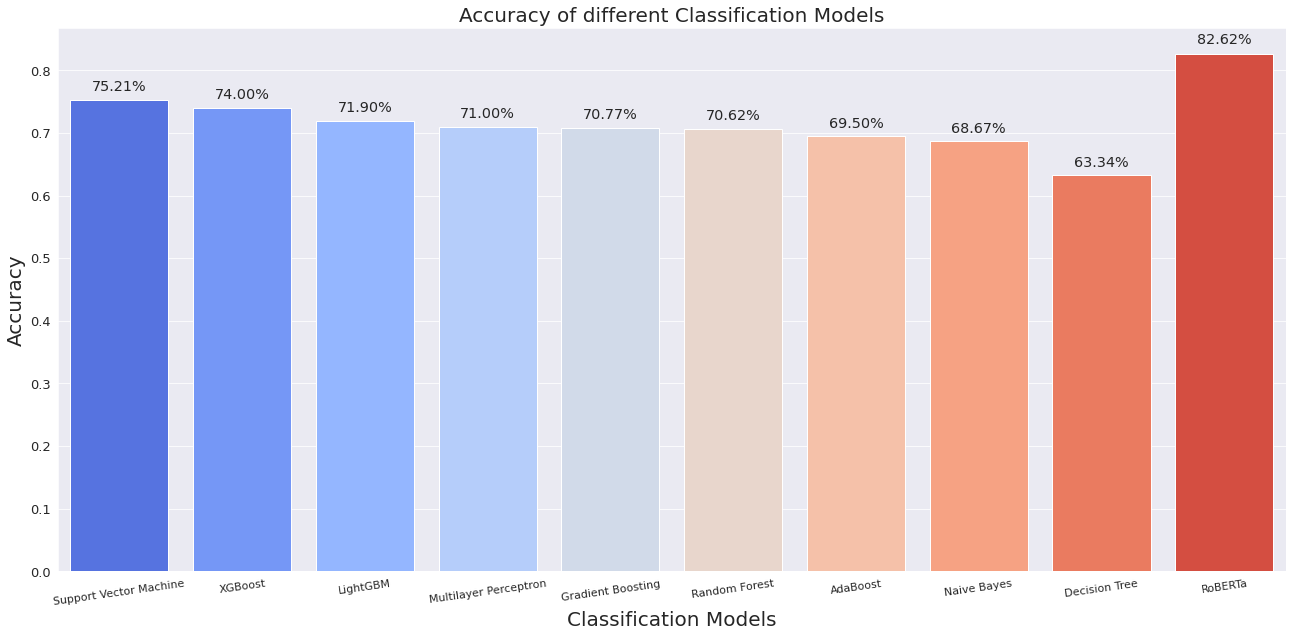

In [17]:
plt.rcParams['figure.figsize']=22,10
sns.set_style("darkgrid")
ax = sns.barplot(x=models_df["Models"], y=models_df["Accuracy Scores"], palette = "coolwarm", saturation =1.5)
plt.xlabel("Classification Models", fontsize = 20 )
plt.ylabel("Accuracy", fontsize = 20)
plt.title("Accuracy of different Classification Models", fontsize = 20)
plt.xticks(fontsize = 11, horizontalalignment = 'center', rotation = 8)
plt.yticks(fontsize = 13)
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height:.2%}', (x + width/2, y + height*1.02), ha='center', fontsize = 'x-large')
plt.show()